![alt text](DataKind_orange.png)

### Binary classification of contract clause types

In [8]:
import os
import gc
from collections import Counter
from itertools import product
import re
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from textstat.textstat import textstat
from langdetect import detect

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [9]:
resource_folder = 'contract_data/Contracts_Annotations/resource_contracts/'
land_folder = 'contract_data/Contracts_Annotations/openland_contracts/'
folders = [resource_folder,land_folder]

In [10]:
target_label = 'royalties'
n_folds = 5

In [11]:
# Languages must be supported by NLTK Snowball Stemmer and stopwords
languages = ['english','french','spanish','italian','portuguese','dutch','swedish']
language_codes = pd.read_csv('http://data.okfn.org/data/core/language-codes/r/language-codes.csv')
language_codes.columns = ['language_code','Language']

In [37]:
models = [DummyClassifier(strategy='most_frequent'),
          LogisticRegression(penalty='l2',C=1,class_weight='balanced',n_jobs=-1),
          RandomForestClassifier(n_estimators=500,
                                 max_features = .33, 
                                 max_depth = None,
#                                  min_samples_leaf = 10,
#                                  min_samples_split = 4,
                                 criterion='gini',
                                 class_weight='balanced_subsample',
#                                  bootstrap=False,
                                 n_jobs=-1,)
         ]

In [13]:
annotations = pd.DataFrame()
for folder in folders:
    xls_files = [f for f in os.listdir(folder) if f.lower().endswith('.xls')]
    for xls in xls_files:
        temp = pd.read_excel(folder + xls)
        if len(temp) > 0:
            temp['OCID'] = xls[:-4]
            temp['Source'] = folder.split('/')[-2]
            annotations = annotations.append(temp)
print "Number of annotations: " + str(len(annotations))

Number of annotations: 20609


In [14]:
annotations.to_pickle('contract_data/Contracts_Annotations/combined_annotations.pkl')

In [15]:
labels = [1 if x.lower() == target_label.lower() else 0 for x in annotations['Category']]
print str("{0:.2f}%".format(100*np.sum(labels) / float(len(labels)))) + " target variable in corpus"

2.37% target variable in corpus


In [16]:
annotations.head(10)

,Category,Topic,Annotation Text,PDF Page Number,Article Reference,OCID,Source
0,Project title,General,Production Sharing Contract between Sociedade ...,1,Preamble,ocds-591adf-0014595575,resource_contracts
1,"Name of field, block, deposit or site",General,Block 20/11,1,Preamble,ocds-591adf-0014595575,resource_contracts
2,Name of company executing document,General,CIE Angola Block 20 LTD (referred to as Cobalt...,3,Preamble,ocds-591adf-0014595575,resource_contracts
3,"State agency, national company or ministry exe...",General,"Sociedade Nacional de Combustiveis de Angola, ...",3,Preamble,ocds-591adf-0014595575,resource_contracts
4,Type of contract,General,Production Sharing Contract,3,Preamble,ocds-591adf-0014595575,resource_contracts
5,Country,General,Angola,3,Preamble,ocds-591adf-0014595575,resource_contracts
6,Parent company or affiliates outside of country,General,"Cobalt, Cayman Islands; BP Exploration Angola ...",3,Preamble,ocds-591adf-0014595575,resource_contracts
7,Resource(s),General,Hydrocarbons,4,Preamble,ocds-591adf-0014595575,resource_contracts
8,Date of issue of title/permit,General,40909,5,Art. 1.15,ocds-591adf-0014595575,resource_contracts
9,Infrastructure,Operations,Contractor Group may construct and install pip...,5,"Arts. 1.18, 19, 20.3, 29.3",ocds-591adf-0014595575,resource_contracts


In [17]:
punctuation_re = r'[^\w\s#]'

def punctuation_remove(text):
    """
    Mutates and returns text where all punctuation besides hashtags,
    are replaced
    """
    new_text = nltk.regexp.re.sub(punctuation_re, ' ', text)
    return new_text

def perform_lowercase(text):
    """
    Mutates and returns text where all characters are lowercased
    """
    try:
        new_text = text.lower()
    except:
        new_text = str(text).lower()
    return new_text

def doublespace_remove(text):
    return re.sub(' +',' ',text)

def textblobsent(text):
    '''
    returns the TextBlob polarity and subjectivity
    '''
    text = text.encode('ascii','ignore')
    sent = TextBlob(text).sentiment
    return pd.Series([sent.polarity,sent.subjectivity])

def get_length(document):
    return len(document)

def get_num_words(document):
    return len(document.split())

def get_avg_wordlength(document):
    wordlengths = [len(word) for word in document.split()]
    if len(wordlengths) == 0:
        return 0
    else:
        return np.mean(wordlengths)

def get_num_syllables(text):
    '''
    returns the number of syllables
    '''
    return textstat.syllable_count(text)

def determine_tense(essay):
    '''
    Returns the number of past, present and future tense verbs in a given text
    '''
    text = word_tokenize(essay)
    tagged = pos_tag(text)

    numfuture = len([word for word in tagged if word[1] == "MD"])
    numpresent = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    numpast = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    
    return pd.Series([numpast,numpresent,numfuture],index=['NumPast','NumPresent','NumFuture'])

def get_pos_tags(text):
    '''
    Returns part of speech tag counts
    '''
    text = word_tokenize(text)
    tagged = pos_tag(text)

    counts = Counter([word[1] for word in tagged]).items()
    countdict = {}
    for key, value in counts:
        countdict[key] = value  
    
    return countdict

def detect_lang(text):
    '''
    Returns detected language
    '''
    text = doublespace_remove(text)
    try:
        return detect(text)
    except:
        return 'None'
    
def remove_stopwords(row):
    '''
    Multilingual stopwords removal
    '''
    language = row['Language']
    if language in languages:
        text = ' '.join([word for word in row['CleanText'].split(' ') if word not in stopwords.words(language)])
        return text
    else:
        return row['CleanText']
    
def stem_words(row):
    ''' 
    Multilingual word stemmer
    '''
    language = row['Language']    
    if language in languages:
        stemmer = SnowballStemmer(language)
        text = ' '.join([stemmer.stem(word) for word in row['CleanText_NoStop'].split(' ')])
        return text
    else:
        return row['CleanText_NoStop']

In [18]:
def clean_text(df):
    df['Annotation Text'].fillna('',inplace=True)
    df['CleanText'] = df['Annotation Text']
    func_list = [perform_lowercase,punctuation_remove,doublespace_remove]
    for func in func_list:
        df['CleanText'] = df['CleanText'].apply(func)

    return df

def featurize(df):
    
    df['NumWords'] = df['CleanText'].apply(get_num_words)
    df['NumCharacters'] = df['CleanText'].apply(get_length)
    df['AvgWordLength'] = df['CleanText'].apply(get_avg_wordlength)
    df['NumSyllables'] = df['CleanText'].apply(get_num_syllables)
    df['language_code'] = df['CleanText'].apply(detect_lang)
    df = df.merge(language_codes,how='left',on='language_code')
    df['Language'] = df['Language'].astype('str')
    df['Language'] = df['Language'].apply(lambda x: x.lower().split(';')[0])
    df['Language'] = df['Language'].apply(lambda x: x if x in languages else 'other')
    df['Language'].fillna('None')
    langdummies = pd.get_dummies(df['Language'],prefix='language_')
    
    df['CleanText_NoStop'] = df.apply(remove_stopwords,axis=1)
    df['CleanText_NoStop_Stemmed'] = df.apply(stem_words,axis=1)
    df.drop(['language_code','Language'],axis=1,inplace=True)
    
    tenses = df['CleanText'].apply(determine_tense)
    tenses.columns = ['tense_' + col for col in tenses.columns]
    
    postagcounts = []
    for index, row in df.iterrows():
        postagcounts.append(get_pos_tags(row['CleanText']))    
    postagdf = pd.DataFrame(postagcounts).fillna(0)
    postagdf.index = df.index
    postagdf.columns = ['postag_' + col for col in postagdf.columns]
    
    textblobsentdf = df['CleanText'].apply(textblobsent)
    textblobsentdf.columns = ['TextblobPolarity','TextblobSubjectivity']
    df = pd.concat([df,textblobsentdf,tenses,postagdf,langdummies],axis=1)
    
    return df

In [19]:
annotations = clean_text(annotations)
annotations = featurize(annotations)

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df= .6,
                                 min_df= .002, 
                                 stop_words=None,  
                                 use_idf=True, 
                                 ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(annotations['CleanText_NoStop_Stemmed'].values.astype('U'))
terms = tfidf_vectorizer.get_feature_names()
tfidf_matrix = tfidf_matrix.todense()
tfidf = pd.DataFrame(tfidf_matrix)
tfidf.index = annotations.index
tfidf.columns = terms
print tfidf.shape

(20609, 12469)


In [22]:
exclude = ['Source','Category','Topic','Annotation Text','CleanText','CleanText_NoStop','CleanText_NoStop_Stemmed',
           'OCID','PDF Page Number','Article Reference','MD','VBP','VBZ','VBG','VBD','VBN','other',"''"]
features = [col for col in annotations.columns.tolist() if not col in exclude]

In [23]:
X = pd.concat([tfidf,annotations[features]],axis=1)

In [24]:
X.fillna(0,inplace=True)
X = X.rename(columns = {'fit':'fit_feature'})

In [25]:
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



**** DummyClassifier ****
5 Fold CV Accuracy Score: 0.976


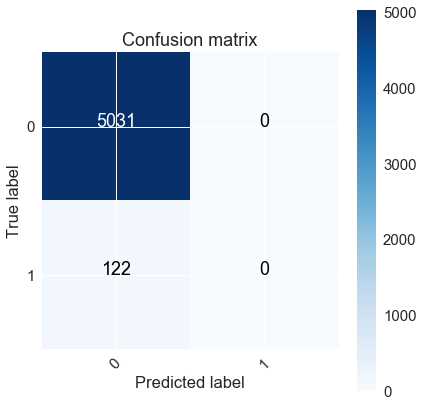



**** LogisticRegression ****
5 Fold CV Accuracy Score: 0.986
*** Test Set Scores ***
    Accuracy: 0.9901
   Precision: 0.7178
      Recall:0.7178
     ROC AUC:0.9749


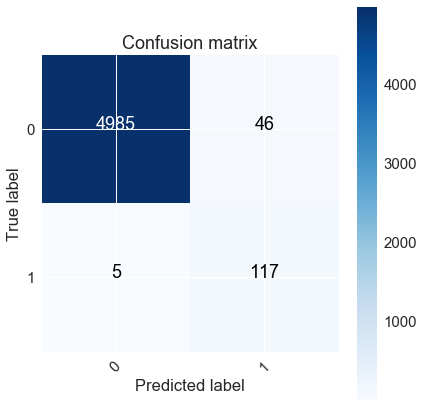



**** RandomForestClassifier ****
5 Fold CV Accuracy Score: 0.992
*** Test Set Scores ***
    Accuracy: 0.9942
   Precision: 0.9107
      Recall:0.9107
     ROC AUC:0.917


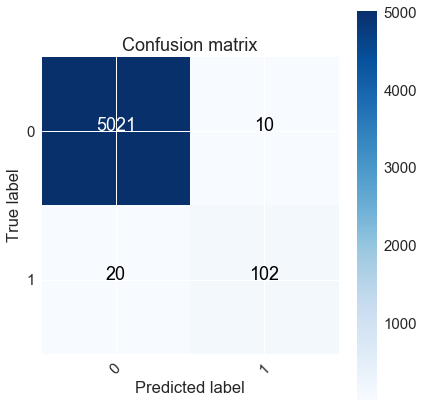

In [38]:
for model in models:
    print '\n'
    print '**** ' + str(model).split('(')[0] + ' ****'
    print str(n_folds) + ' Fold CV Accuracy Score: ' + str(round(np.mean(cross_val_score(model, X, y, cv=n_folds)),3))
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if not str(model).split('(')[0] == 'DummyClassifier':
        print '*** Test Set Scores ***'
        print '    Accuracy: ' + str(round(accuracy_score(y_test, test_pred),4))
        print '   Precision: ' + str(round(precision_score(y_test, test_pred),4))
        print '      Recall:'  + str(round(precision_score(y_test, test_pred),4))
        print '     ROC AUC:'  + str(round(roc_auc_score(y_test, test_pred),4))
        
    cnf_matrix = confusion_matrix(y_test, test_pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    sns.set_context(rc={"figure.figsize": (6, 6)})       
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=np.unique(y),
                              title='Confusion matrix')

Accuracy: 0.9942
Precision: 0.9107
Recall:0.9107
ROC AUC:0.917

Accuracy: 0.994
Precision: 0.9174
Recall:0.9174
ROC AUC:0.9089

Accuracy: 0.9917
Precision: 0.811
Recall:0.811
ROC AUC:0.9197

Accuracy: 0.992
Precision: 0.785
Recall:0.785
ROC AUC:0.96

In [28]:
def get_feature_importances(clf,X):
    '''
    returns feature importances
    '''
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_importance = pd.DataFrame(X.columns, importances)    
    feat_importance.reset_index(inplace=True)
    feat_importance.columns = ['Importance','Feature']
    feat_importance.sort_values(by='Importance', axis=0, ascending=True, inplace=True)
    feat_importance.set_index('Feature',inplace=True)
    return feat_importance

In [29]:
importances = {}
importances = get_feature_importances(model,X)
importances.index.name=None
display(importances.sort_values(by='Importance',ascending=False).head(20))

,Importance
royalti,0.169220
redev,0.112582
pai,0.101876
AvgWordLength,0.056894
taux,0.053223
pay,0.043921
TextblobPolarity,0.043607
proportionnel,0.020399
NumWords,0.016156
redev proportionnel,0.015708


### Pickle Model

In [30]:
joblib.dump(model, target_label + '_binary.pkl',compress=9)

TypeError: dump() takes at least 2 arguments (2 given)